In [35]:
%matplotlib inline
import os
import re
import io
import itertools

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
from climatools.lblnew.dataio import *
from climatools.plot.plot import *


import IPython.display as display


In [36]:
DIR_FORTRAN_CLIRAD = os.path.join('/chia_cluster/home/jackyu',
                                  'radiation',
                                  'clirad-lw/LW/examples/lblnew/now')

PATH_FLUX_CLIRAD = os.path.join(DIR_FORTRAN_CLIRAD, 
                                'output_flux.dat')
PATH_COOLR_CLIRAD = os.path.join(DIR_FORTRAN_CLIRAD, 
                                 'output_coolr.dat')
PATH_FLUXG_CLIRAD = os.path.join(DIR_FORTRAN_CLIRAD, 
                                 'output_fluxg.dat')
PATH_COOLRG_CLIRAD = os.path.join(DIR_FORTRAN_CLIRAD, 
                                  'output_coolrg.dat')

In [37]:
# option_wgt_flux = 2
DIR_FORTRAN_LBLNEW = os.path.join('/chia_cluster/home/jackyu/radiation/crd/LW/examples/separate_g_groups/study__lblnew_g1_threshold/h2o/band01_wn_20_340/nv_200/dv_0.005/ng_10/g_ascending_k_descending/refPTs_P_1_T_250__P_30_T_250__P_300_T_250/ng_refs_3__2__5/getabsth_auto__auto__auto/absth_dlogN_uniform__dlogN_uniform__dlogN_uniform/klin_none/atmpro_mls/wgt_k_1/wgt_0.3_0.3_0.3__0.3_0.3__0.3_0.6_0.6_0.6_0.6/wgt_flux_2/w_diffuse_1.6_1.8_1.8__1.8_1.7__1.6_1.4_1.4_1.7_1.8/option_compute_ktable_1/crd_094286f')
# CRD
PATH_FLUXG_LBLNEW = os.path.join(DIR_FORTRAN_LBLNEW, 
                                 'output_fluxg.dat')
PATH_COOLRG_LBLNEW = os.path.join(DIR_FORTRAN_LBLNEW, 
                                  'output_coolrg.dat')

# k-dist, diffusivity, table look-up
PATH_WFLUXG_LBLNEW = os.path.join(DIR_FORTRAN_LBLNEW,
                                   'output_wfluxg.dat')
PATH_WCOOLRG_LBLNEW = os.path.join(DIR_FORTRAN_LBLNEW,
                                    'output_wcoolrg.dat')

In [38]:
def load_output_file(path_csv):
    '''
    Load lblnew output .csv file to xarray.Dataset
    
    Parameters
    ----------
    path_csv: str
              Path to the .csv file to be loaded.
    ds: xarray.Dataset
        Data in the input file in the form of an xarray.Dataset.
    '''
    toindex = ['band', 'pressure', 'igg', 'g']    
    df = pd.read_csv(path_csv, sep=r'\s+')
    df = df.set_index([i for i in toindex if i in df.columns])
    df = df.rename(columns={'sfu': 'flug',
                           'sfd': 'fldg',
                           'fnet': 'fnetg',
                           'coolr': 'coolrg'})
    ds = xr.Dataset.from_dataframe(df)
    return ds

In [39]:
DS_FLUX_CLIRAD = load_output_file(PATH_FLUX_CLIRAD)
DS_COOLR_CLIRAD = load_output_file(PATH_COOLR_CLIRAD)
DS_FLUXG_CLIRAD = load_output_file(PATH_FLUXG_CLIRAD)
DS_COOLRG_CLIRAD = load_output_file(PATH_COOLRG_CLIRAD)

In [40]:
DS_FLUXG_LBLNEW = load_output_file(PATH_FLUXG_LBLNEW)
DS_COOLRG_LBLNEW = load_output_file(PATH_COOLRG_LBLNEW)
DS_WFLUXG_LBLNEW = load_output_file(PATH_WFLUXG_LBLNEW)
DS_WCOOLRG_LBLNEW = load_output_file(PATH_WCOOLRG_LBLNEW)

In [41]:
def pltdata_cooling_1(ds_coolr_clirad=None,
                      ds_coolrg_clirad=None,
                      ds_coolrg_lblnew=None,
                      ds_wcoolrg_lblnew=None,
                      ds_coolrg_lblnew1=None,
                      ds_wcoolrg_lblnew1=None,
                      ds_coolrg_lblnew2=None,
                      ds_wcoolrg_lblnew2=None
                     ):
    data = [{'label': 'CLIRAD `coolrk`',
             'linestyle': ':', 'color': 'cyan', 'marker': 'd',
             'srs': ds_coolrg_clirad['coolrg'].sel(band=1).sum('g')},
            {'label': 'CRD',
             'linestyle': '--', 'color': 'blue', 'marker': None,
             'srs': ds_coolrg_lblnew['coolrg'].sum('g')},
           {'label': 'WGT igg=10 wgt_flux=2',
             'linestyle': '-', 'color': 'orange', 'marker': '.',
             'srs': ds_wcoolrg_lblnew['coolrg'].sel(igg=10).sum('g')}]
    return data


def pltdata_cooling_2(ds_coolr_clirad=None,
                      ds_coolrg_clirad=None,
                      ds_coolrg_lblnew=None,
                      ds_wcoolrg_lblnew=None,
                      ds_coolrg_lblnew1=None,
                      ds_wcoolrg_lblnew1=None,
                      ds_coolrg_lblnew2=None,
                      ds_wcoolrg_lblnew2=None
                     ):
    data = [{'label': 'CRD',
             'linestyle': '--', 'color': 'blue', 'marker': None,
             'srs': ds_coolrg_lblnew['coolrg'].sum('g')},
            ]
    return data


def pltdata_cooling_3(ds_coolr_clirad=None,
                      ds_coolrg_clirad=None,
                      ds_coolrg_lblnew=None,
                      ds_wcoolrg_lblnew=None,
                      ds_coolrg_lblnew1=None,
                      ds_wcoolrg_lblnew1=None,
                      ds_coolrg_lblnew2=None,
                      ds_wcoolrg_lblnew2=None
                     ):
    data = [{'label': 'CLIRAD `coolrk`',
             'linestyle': ':', 'color': 'cyan', 'marker': 'd',
             'srs': ds_coolrg_clirad['coolrg'].sel(band=1).sum('g')},
            {'label': 'CRD',
             'linestyle': '--', 'color': 'blue', 'marker': None,
             'srs': ds_coolrg_lblnew['coolrg'].sum('g')},
            {'label': 'WGT igg=10 wgt_flux=2',
             'linestyle': '-', 'color': 'orange', 'marker': '.',
             'srs': ds_wcoolrg_lblnew['coolrg'].sel(igg=10).sum('g')}]
    return data


def plt_cooling(pltdata=None):
    '''
    Plots a list of cooling rate profiles.
    
    Parameter
    ---------
    pltdata: list-like
             List of dictionaries each of which contains the following
             fields:
                 label -- 
    '''
    
    plot_args = {'index_on_yaxis': True,
                 'yincrease': False,
                 'linewidth': 3,
                 'grid': True,
                 'alpha': .5}
    
    yscales = ['linear', 'log']
    varlims = [(50, 1050), (1e-2, 200)]
    
    fig, axs = plt.subplots(ncols=len(yscales), nrows=1,
                            figsize=(15, 6))
    
    axs = axs.flatten()
    
    for ax, yscale, varlim in zip(axs, yscales, varlims):
        for d in pltdata:
            d['srs'].climaviz.plot(ax=ax,
                                  yscale=yscale,
                                   varlim_from_indexrange=varlim,
                                  label=d['label'],
                                  linestyle=d['linestyle'],
                                  color=d['color'],
                                  marker=d['marker'],
                                  **plot_args)
            
        ax.set_title('')
        
        ax.set_ylabel('Pressure (mb)')
        ax.set_ylim(top=1e-2)
        ax.set_ylim(bottom=None)
    
        ax.set_xlabel('Cooling rate (degree per day)')
    return fig, axs



def script_plt_cooling():

    matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'grey',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 
    for f in [pltdata_cooling_1]:
        pltdata = f(ds_coolr_clirad=DS_COOLR_CLIRAD,
                    ds_coolrg_clirad=DS_COOLRG_CLIRAD,
                    ds_coolrg_lblnew=DS_COOLRG_LBLNEW,
                    ds_wcoolrg_lblnew=DS_WCOOLRG_LBLNEW)

        fig, axs = plt_cooling(pltdata=pltdata)
    
        display.display(fig)
        print('Figure: Cooling rate profile comparison.')
    
        plt.close(fig)
    
    

In [42]:

def tbdata_flux(ds_flux_clirad=None,
                ds_fluxg_clirad=None,                
                ds_fluxg_lblnew=None,
                ds_wfluxg_lblnew=None,):
    ilevels = [0, -1]
    
    def fmt(ds):
        return ds.isel(pressure=ilevels)\
                 .to_dataframe()\
                 .set_index('level', append=True)\
                 .drop('igg', axis=1, errors='ignore')
            
    benchmark = {'label': 'CRD',
                  'df': fmt(ds_fluxg_lblnew)}
    
    tbs = [{'label': 'WGT igg=10 wgt_flux=2',
            'df': fmt(ds_wfluxg_lblnew.sel(igg=10))},
           {'label': 'CLIRAD coolrk',
            'df': fmt(ds_fluxg_clirad)}]
    
    data = {'benchmark': benchmark, 'others': tbs}
    return data


def tb_flux(tbdata=None):
    benchmark = tbdata['benchmark']
    others = tbdata['others']
    
    def show_tb(d=None):
        display.display(d['df'])
        print('Table:', 'TOA and SFC flux.', d['label'])
        
    def show_tbdiff(d0=None, d=None):
        df = d['df']
        df.index = d0['df'].index
        display.display(df - d0['df'])
        print('Table:', 'TOA and SFC flux.', 
              '({}) - ({})'.format(d['label'], d0['label']))
        
    show_tb(benchmark)
    for d in others:
        show_tb(d)
        
    for d in others:
        show_tbdiff(d=d, d0=benchmark)
        
        
def script_tb_fluxg():
    data = tbdata_flux(ds_fluxg_clirad=DS_FLUXG_CLIRAD,
                       ds_flux_clirad=DS_FLUX_CLIRAD,
                       ds_fluxg_lblnew=DS_FLUXG_LBLNEW,
                       ds_wfluxg_lblnew=DS_WFLUXG_LBLNEW)
    tb_flux(tbdata=data)
    



In [43]:
def load_debug_bd():
    s = os.path.join(DIR_FORTRAN_CLIRAD, 'debug_bd.dat')
    df = pd.read_csv(s, sep=r'\s+')
    return df


def load_debug_xx():
    s = os.path.join(DIR_FORTRAN_CLIRAD, 'debug_xx.dat')
    df = pd.read_csv(s, sep=r'\s+')
    return df


def load_debug_h2oexps():
    s = os.path.join(DIR_FORTRAN_CLIRAD, 'h2oexp.csv')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['layer', 'g'])
    return df


def script_debug():
    display.display(display.Markdown('# Debug Info'))
    pd.set_option('display.max_rows', None)
    display.display(load_debug_bd())
    display.display(load_debug_xx())
    display.display(load_debug_h2oexps())
    pd.reset_option('display.max_rows')


In [44]:
# Check interpolation function's results

def load_ktest():
    s = os.path.join(DIR_FORTRAN_CLIRAD, 'debug_ktest.dat')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['g', 'pressure', 'temperature'])
    ds = xr.Dataset.from_dataframe(df)
    return df


def load_ktable():
    s = os.path.join('/chia_cluster/home/jackyu/radiation',
                     'crd/LW/examples/separate_g_groups',
                     'study__lblnew_g1_threshold',
                     'h2o/band01_wn_20_340/nv_200',
                     'dv_0.005/ng_10',
                     'g_ascending_k_descending',
                     'refPTs_P_1_T_250__P_30_T_250__P_300_T_250',
                     'ng_refs_3__2__5',
                     'getabsth_auto__auto__auto',
                     'absth_dlogN_uniform__dlogN_uniform__dlogN_uniform',
                     'wgt_0.3_0.3_0.3__0.3_0.3__0.3_0.6_0.6_0.6_0.6',
                     'wgt_flux_2/wgt_k_1/klin_none',
                     'w_diffuse_1.6_1.8_1.8__1.8_1.7__1.6_1.4_1.4_1.7_1.8',
                     'crd_9d81085',
                     'atmpro_mls',
                     'ktable.dat')
    df = pd.read_csv(s, sep=r'\s+')
    df = df.set_index(['g', 'pressure', 'temperature'])
    ds = xr.Dataset.from_dataframe(df)
    return df



def plt_fractional_error():
    clirad = load_ktest()
    crd = load_ktable()
    
    #print(clirad[clirad['k'] < 0])
    #print(crd[crd['k'] < 0])
    
    clirad.index = crd.index
    diff = (clirad - crd) / crd
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(11, 5))
    diff.hist(ax=ax, bins=20, color='grey', alpha=.6)
    ax.set_xlabel('fractional deviation')
    ax.set_ylabel('number of (P,T) pairs')
    
    return fig


def script_bilinear_interp():
    
    display.display(display.Markdown('# Bilinear interpolation'))
    
    fig = plt_fractional_error()
    display.display(fig)
    print('Figure. Fractional deviation of'
          ' interpolated absorption coefficient from CRD'
         ' at ktable (pressure, temperature) pairs')
    plt.close(fig)



In [45]:
#script_bilinear_interp()

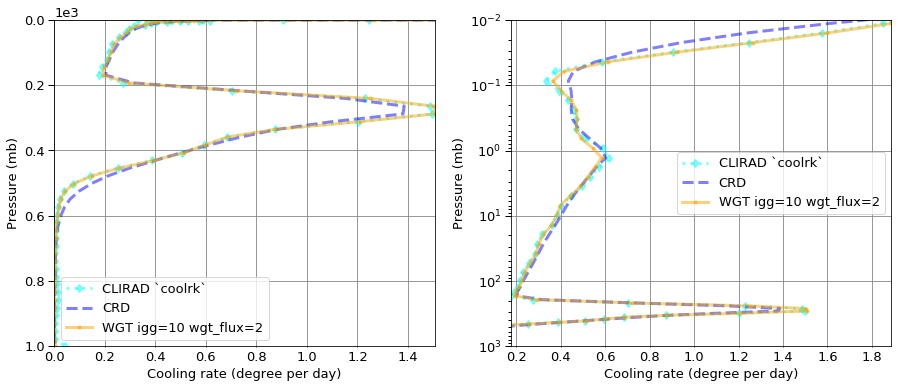

Figure: Cooling rate profile comparison.


In [46]:
script_plt_cooling()

In [47]:
script_tb_fluxg()

flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007271   0.000000  -0.007271
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.017996   0.000000  -0.017996
   1013.0   76     -0.025527   0.025521  -0.000007
3  0.0      1      -0.050264   0.000000  -0.050264
   1013.0   76     -0.060809   0.060794  -0.000015
4  0.0      1      -0.113820   0.000000  -0.113820
   1013.0   76     -0.142595   0.142560  -0.000035
5  0.0      1      -0.339652   0.000000  -0.339652
   1013.0   76     -0.477034   0.476917  -0.000117
6  0.0      1      -0.717453   0.000000  -0.717453
   1013.0   76     -1.119475   1.119201  -0.000274
7  0.0      1      -2.367531   0.000000  -2.367531
   1013.0   76     -3.892565   3.891610  -0.000954
8  0.0      1      -7.049878   0.000000  -7.049878
   1013.0   76    -11.170086  11.167328  -0.002758
9  0.0      1     -12.381325   0.000000 -12.381325
   1013.0   76    -18.390455  18.385790  -0.004664
10 0.0      1     -11.186593   0.000000 -11.186593
   1013.0   76    -15.782424  15.777909  -0.004515

Table: TOA and SFC flux. CRD


flug       fldg      fnetg
g  pressure level                                 
1  0.0      1      -0.007171   0.000000  -0.007171
   1013.0   76     -0.012460   0.012457  -0.000003
2  0.0      1      -0.017785   0.000000  -0.017785
   1013.0   76     -0.025527   0.025521  -0.000007
3  0.0      1      -0.051052   0.000000  -0.051052
   1013.0   76     -0.060809   0.060794  -0.000015
4  0.0      1      -0.115513   0.000000  -0.115513
   1013.0   76     -0.142595   0.142560  -0.000035
5  0.0      1      -0.342330   0.000000  -0.342330
   1013.0   76     -0.477034   0.476917  -0.000117
6  0.0      1      -0.719070   0.000000  -0.719070
   1013.0   76     -1.119475   1.119201  -0.000274
7  0.0      1      -2.348196   0.000000  -2.348196
   1013.0   76     -3.892565   3.891610  -0.000954
8  0.0      1      -7.037719   0.000000  -7.037719
   1013.0   76    -11.170086  11.167328  -0.002758
9  0.0      1     -12.295566   0.000000 -12.295566
   1013.0   76    -18.390455  18.385790  -0.004664
10 0.0      1     -11.098740   0.000000 -11.098740
   1013.0   76    -15.782424  15.777921  -0.004503

Table: TOA and SFC flux. WGT igg=10 wgt_flux=2


flug          fldg      fnetg
band g  pressure     level                                    
1    1  1.000000e-08 1      -0.007080  7.408671e-07  -0.007079
        1.013000e+03 76     -0.012622  1.259192e-02  -0.000030
     2  1.000000e-08 1      -0.017861  7.636845e-08  -0.017861
        1.013000e+03 76     -0.025648  2.558664e-02  -0.000061
     3  1.000000e-08 1      -0.051475  1.117587e-08  -0.051475
        1.013000e+03 76     -0.061703  6.155586e-02  -0.000147
     4  1.000000e-08 1      -0.115544  0.000000e+00  -0.115544
        1.013000e+03 76     -0.145286  1.449384e-01  -0.000347
     5  1.000000e-08 1      -0.339003  0.000000e+00  -0.339003
        1.013000e+03 76     -0.486309  4.851463e-01  -0.001162
     6  1.000000e-08 1      -0.706198  0.000000e+00  -0.706198
        1.013000e+03 76     -1.141805  1.139077e+00  -0.002729
     7  1.000000e-08 1      -2.301836  0.000000e+00  -2.301836
        1.013000e+03 76     -3.967865  3.958382e+00  -0.009483
     8  1.000000e-08 1      -6.960315  0.000000e+00  -6.960315
        1.013000e+03 76    -11.360820  1.133367e+01  -0.027150
     9  1.000000e-08 1     -12.268563  0.000000e+00 -12.268563
        1.013000e+03 76    -18.557241  1.851289e+01  -0.044350
     10 1.000000e-08 1     -11.148226  0.000000e+00 -11.148226
        1.013000e+03 76    -15.332851  1.529621e+01  -0.036643

Table: TOA and SFC flux. CLIRAD coolrk


flug      fldg     fnetg
g  pressure level                              
1  0.0      1      0.000100  0.000000  0.000100
   1013.0   76     0.000000  0.000000  0.000000
2  0.0      1      0.000211  0.000000  0.000211
   1013.0   76     0.000000  0.000000  0.000000
3  0.0      1     -0.000788  0.000000 -0.000788
   1013.0   76     0.000000  0.000000  0.000000
4  0.0      1     -0.001692  0.000000 -0.001692
   1013.0   76     0.000000  0.000000  0.000000
5  0.0      1     -0.002678  0.000000 -0.002678
   1013.0   76     0.000000  0.000000  0.000000
6  0.0      1     -0.001617  0.000000 -0.001617
   1013.0   76     0.000000  0.000000  0.000000
7  0.0      1      0.019336  0.000000  0.019336
   1013.0   76     0.000000  0.000000  0.000000
8  0.0      1      0.012159  0.000000  0.012159
   1013.0   76     0.000000  0.000000  0.000000
9  0.0      1      0.085759  0.000000  0.085759
   1013.0   76     0.000000  0.000000  0.000000
10 0.0      1      0.087853  0.000000  0.087853
   1013.0   76     0.000000  0.000012  0.000012

Table: TOA and SFC flux. (WGT igg=10 wgt_flux=2) - (CRD)


flug          fldg     fnetg
g  pressure level                                  
1  0.0      1      0.000191  7.408671e-07  0.000192
   1013.0   76    -0.000162  1.349700e-04 -0.000027
2  0.0      1      0.000135  7.636845e-08  0.000135
   1013.0   76    -0.000121  6.600600e-05 -0.000055
3  0.0      1     -0.001211  1.117587e-08 -0.001211
   1013.0   76    -0.000894  7.619260e-04 -0.000132
4  0.0      1     -0.001724  0.000000e+00 -0.001724
   1013.0   76    -0.002690  2.378220e-03 -0.000312
5  0.0      1      0.000649  0.000000e+00  0.000649
   1013.0   76    -0.009275  8.229640e-03 -0.001045
6  0.0      1      0.011256  0.000000e+00  0.011256
   1013.0   76    -0.022331  1.987560e-02 -0.002455
7  0.0      1      0.065695  0.000000e+00  0.065695
   1013.0   76    -0.075300  6.677180e-02 -0.008528
8  0.0      1      0.089563  0.000000e+00  0.089563
   1013.0   76    -0.190734  1.663420e-01 -0.024392
9  0.0      1      0.112762  0.000000e+00  0.112762
   1013.0   76    -0.166786  1.271020e-01 -0.039685
10 0.0      1      0.038367  0.000000e+00  0.038367
   1013.0   76     0.449573 -4.817010e-01 -0.032128

Table: TOA and SFC flux. (CLIRAD coolrk) - (CRD)


In [48]:
#script_tb_fluxg()

In [49]:
#pd.set_option('display.max_rows', None)
#display.display(DS_FLUX.sel(band=1).to_dataframe())
#pd.reset_option('display.max_rows')

In [50]:
#script_debug()

In [51]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')